<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/cats_dogs/cats_dogs_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify dogs and cats with Binary CNN
[Original Kaggle Notebook](https://www.kaggle.com/datasets/tongpython/cat-and-dog)

# Import Data and helpers

In [1]:
import os
list_dir = os.listdir('.')

if 'cat_dog.zip?dl=0' not in list_dir:
  # import dataset
  !wget https://www.dropbox.com/s/qpul0hnbovcnmmb/cat_dog.zip?dl=0

  # import helpers
  !wget !wget !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-07 18:54:18--  https://www.dropbox.com/s/qpul0hnbovcnmmb/cat_dog.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qpul0hnbovcnmmb/cat_dog.zip [following]
--2022-06-07 18:54:19--  https://www.dropbox.com/s/raw/qpul0hnbovcnmmb/cat_dog.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b2491b50fb6e0e0cfff7ea808.dl.dropboxusercontent.com/cd/0/inline/BmyqdTD3IxypHoi8DjUw3wIxx9IgeaQpta4vWd9XPOzay4JHQkSjCzs06k8XaL648GdWSC2-j2aYtGu3q1mJ1rHcbDfV4tWBrEJNKr-HqPynFC2LvSsZgte7WVIk_VVQE467HYl8Deh4DNhPZPpYhWK6tu312bPP7_JQzejxVVslAA/file# [following]
--2022-06-07 18:54:20--  https://uc5b2491b50fb6e0e0cfff7ea808.dl.dropboxusercontent.com/cd/0/inline/BmyqdTD3IxypHoi8DjUw3wIxx9IgeaQpta4vWd9XPOzay4JHQkSjCzs06k8XaL6

In [2]:
from helper_functions import plot_loss_curves, walk_through_dir, compare_historys, unzip_data

In [3]:
list_dir = os.listdir('.')
if 'images' not in list_dir:
  unzip_data('cat_dog.zip?dl=0')


In [4]:
walk_through_dir('images/train_10_percent')

There are 2 directories and 0 images in 'images/train_10_percent'.
There are 0 directories and 400 images in 'images/train_10_percent/cats'.
There are 0 directories and 400 images in 'images/train_10_percent/dogs'.


# Preprocess Data

In [5]:
data_augmentation_dial = 0.2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create dat augmentation stage wsith horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(data_augmentation_dial),
                                      preprocessing.RandomZoom(data_augmentation_dial),
                                      preprocessing.RandomHeight(data_augmentation_dial),
                                      preprocessing.RandomWidth(data_augmentation_dial),
                                      
                                      # Keep for models like ResNet50v2 but efficientNet's 
                                      # having resclaing built in means we don't need it for this model
                                      # preprocessing.Rescale(1./255)
], name='data_augmentation')

In [6]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'images/test',
    label_mode='binary',
    image_size=(224, 224),
)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'images/train',
    label_mode='binary',
    image_size=(224, 224),
)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'images/train_10_percent',
    label_mode='binary',
    image_size=(224, 224),
)

Found 2022 files belonging to 2 classes.
Found 8000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


# Create base model

In [7]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

# If using a model like ResNet50v2 you will need to normalize inputs (you don't have to if you're using efficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)



16719872/16705208 [==============================] - 0s 0us/step


# Create Checkpoint callback

In [8]:
checkpoint_path = 'efficientNetB0/checkpoint.ckpt'
initial_epochs = 5

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    # save_freq="epoch"
    period=initial_epochs,
    verbose=1
)

# EfficientNetB0

## Model 1: Feature Extraction


In [9]:
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


history_1 = model_1.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    callbacks=[checkpoint_callback]
)



Epoch 1/5
25/25 [==============================] - 22s 260ms/step - loss: 0.4271 - accuracy: 0.8550 - val_loss: 0.2355 - val_accuracy: 0.9570
Epoch 2/5
25/25 [==============================] - 4s 171ms/step - loss: 0.2230 - accuracy: 0.9475 - val_loss: 0.1477 - val_accuracy: 0.9629
Epoch 3/5
25/25 [==============================] - 4s 168ms/step - loss: 0.1631 - accuracy: 0.9563 - val_loss: 0.1208 - val_accuracy: 0.9766
Epoch 4/5
25/25 [==============================] - 5s 170ms/step - loss: 0.1330 - accuracy: 0.9650 - val_loss: 0.0960 - val_accuracy: 0.9805
Epoch 5/5
25/25 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.9613
Epoch 5: saving model to efficientNetB0/checkpoint.ckpt
INFO:tensorflow:Assets written to: efficientNetB0/checkpoint.ckpt/assets
25/25 [==============================] - 39s 2s/step - loss: 0.1258 - accuracy: 0.9613 - val_loss: 0.0939 - val_accuracy: 0.9824


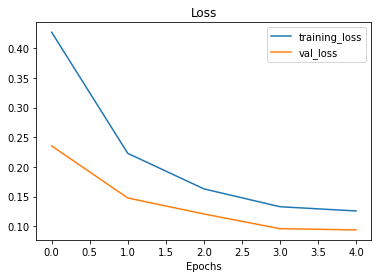

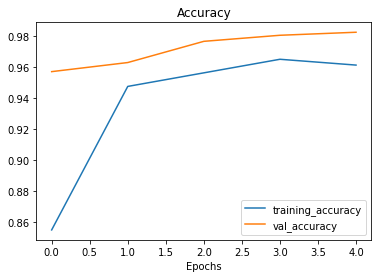

In [10]:
plot_loss_curves(history_1)

In [12]:
model_1_results = model_1.evaluate(test_data)

64/64 [==============================] - 4s 56ms/step - loss: 0.0805 - accuracy: 0.9817


## Model 2: Fine Tuning
EfficientNetB0 gives us great results right off the bat with data augmentation and with only 10% of the training data.

Now let's try to unfreeze 10% layers and train on our own custom data

In [13]:
base_model.trainable = True

# Freeze all layers except the last 10%
for layer in base_model.layers[:- int(.10 * len(base_model.layers))]:
  layer.trainable = False

Epoch 5/10
250/250 [==============================] - 37s 117ms/step - loss: 0.1333 - accuracy: 0.9505 - val_loss: 0.0421 - val_accuracy: 0.9863
Epoch 6/10
250/250 [==============================] - 25s 99ms/step - loss: 0.0812 - accuracy: 0.9685 - val_loss: 0.0598 - val_accuracy: 0.9922
Epoch 7/10
250/250 [==============================] - 24s 94ms/step - loss: 0.0666 - accuracy: 0.9760 - val_loss: 0.0691 - val_accuracy: 0.9883
Epoch 8/10
250/250 [==============================] - 23s 92ms/step - loss: 0.0570 - accuracy: 0.9762 - val_loss: 0.0124 - val_accuracy: 0.9961
Epoch 9/10
250/250 [==============================] - 22s 85ms/step - loss: 0.0514 - accuracy: 0.9814 - val_loss: 0.0662 - val_accuracy: 0.9902
Epoch 10/10
250/250 [==============================] - 22s 86ms/step - loss: 0.0464 - accuracy: 0.9824 - val_loss: 0.0737 - val_accuracy: 0.9883


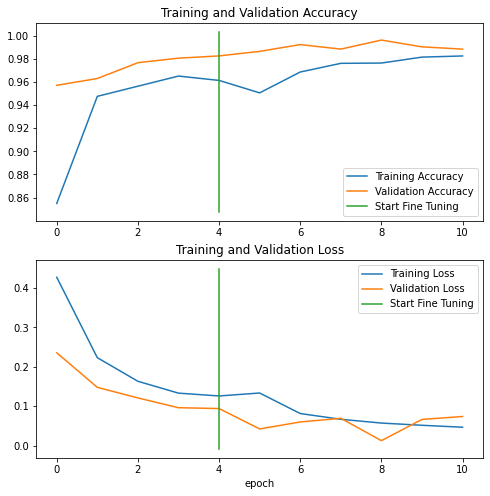

In [14]:
# # Create new model and recompile & fit
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)
model_2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_2 = model_2.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_1.epoch[-1]
)
compare_historys(history_1, history_2)

In [ ]:
model_2_results = model_2.evaluate(test_data)

**Summary:** EfficientNetB0 gave us a high accuracy score and the improvement from unfreezing layers is minimal.

# ResNet50V2

EfficientNetB0 proved to be usefull even before fine tuning, so let's try a different popular model to compare results

In [ ]:
# Create New Checkpoint
checkpoint_path = 'resNet50V2/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    period=initial_epochs,
    verbose=1
)

In [ ]:
# Create base model
input_shape = (224, 224, 3)

resNet_model = tf.keras.applications.ResNet50V2(include_top=False)
resNet_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')


x = data_augmentation(inputs)

x = resNet_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)



## Model 3

Epoch 1/5
25/25 [==============================] - 8s 170ms/step - loss: 60.9108 - accuracy: 0.4725 - val_loss: 19.5943 - val_accuracy: 0.5508
Epoch 2/5
25/25 [==============================] - 4s 143ms/step - loss: 22.3923 - accuracy: 0.5275 - val_loss: 21.4221 - val_accuracy: 0.5234
Epoch 3/5
25/25 [==============================] - 4s 142ms/step - loss: 13.2217 - accuracy: 0.5587 - val_loss: 16.7298 - val_accuracy: 0.5059
Epoch 4/5
25/25 [==============================] - 4s 139ms/step - loss: 8.8960 - accuracy: 0.5437 - val_loss: 5.7301 - val_accuracy: 0.5977
Epoch 5/5
25/25 [==============================] - ETA: 0s - loss: 10.6787 - accuracy: 0.5550
Epoch 5: saving model to resNet50V2/checkpoint.ckpt
INFO:tensorflow:Assets written to: resNet50V2/checkpoint.ckpt/assets
25/25 [==============================] - 24s 981ms/step - loss: 10.6787 - accuracy: 0.5550 - val_loss: 13.7618 - val_accuracy: 0.5547


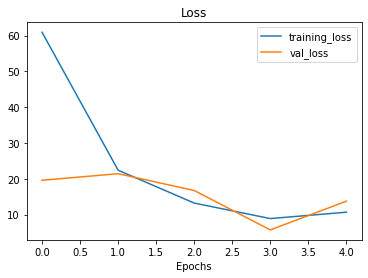

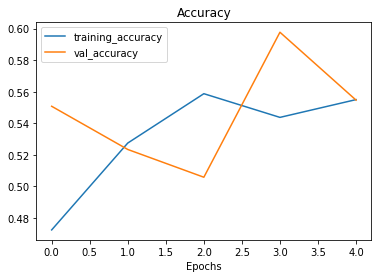

In [ ]:
# Compile & Fit the model

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics='accuracy')
history_3 = model_3.fit(
  train_data_10_percent,
  epochs = initial_epochs,
  steps_per_epoch=len(train_data_10_percent),
  validation_data=test_data,
  validation_steps=int(.25 * len(test_data)),
  callbacks=[checkpoint_callback]
)
plot_loss_curves(history_3)

In [ ]:
model_3_results = model_3.evaluate(test_data)

64/64 [==============================] - 4s 64ms/step - loss: 14.1773 - accuracy: 0.5603


Not very good results with ResNet50V2

Let's try unfreezing some layers and training on full test dataset to see if model improves

Let's try unlocking the last 10% of base layers

In [ ]:
resNet_model.trainable = True

# Freeze all layers except the last 10%
for layer in resNet_model.layers[:- int(.10 * len(resNet_model.layers))]:
  layer.trainable = False



##Model 4

Epoch 5/10
250/250 [==============================] - 32s 106ms/step - loss: 455807.6250 - accuracy: 0.4913 - val_loss: 0.6951 - val_accuracy: 0.4766
Epoch 6/10
250/250 [==============================] - 25s 99ms/step - loss: 0.6933 - accuracy: 0.4890 - val_loss: 0.6931 - val_accuracy: 0.5156
Epoch 7/10
250/250 [==============================] - 25s 98ms/step - loss: 2324.4893 - accuracy: 0.5034 - val_loss: 0.6931 - val_accuracy: 0.5117
Epoch 8/10
250/250 [==============================] - 25s 99ms/step - loss: 0.6933 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 9/10
250/250 [==============================] - 25s 98ms/step - loss: 0.6933 - accuracy: 0.4942 - val_loss: 0.6928 - val_accuracy: 0.5215
Epoch 10/10
250/250 [==============================] - 25s 98ms/step - loss: 0.6933 - accuracy: 0.4995 - val_loss: 0.6930 - val_accuracy: 0.5117


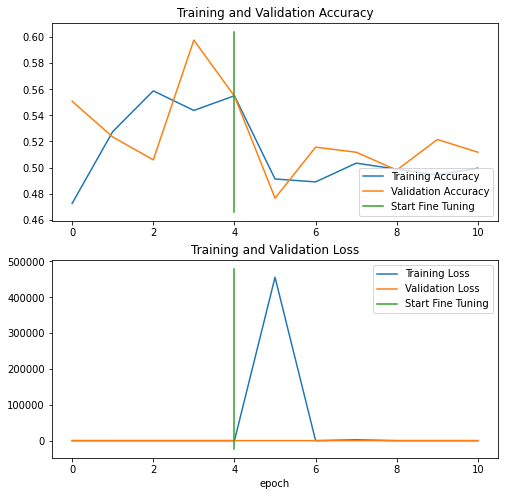

In [ ]:
# # Create new model and recompile & fit
model_4 = tf.keras.Model(inputs, outputs)
model_4.load_weights(checkpoint_path)
model_4.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_4 = model_4.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_3.epoch[-1]
)
compare_historys(history_3, history_4)




In [ ]:
model_4_results = model_4.evaluate(test_data)

64/64 [==============================] - 4s 64ms/step - loss: 0.6932 - accuracy: 0.5000


Summary: ResNet50V2 did not perform nearly as well as efficientNetB0. Let's try one more model 

# Xception

In [ ]:
# Create New Checkpoint
checkpoint_path = 'xception/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    period=initial_epochs,
    verbose=1
)

In [ ]:
# Create base model
input_shape = (224, 224, 3)

xception_model = tf.keras.applications.Xception(include_top=False)
xception_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = xception_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)



## Model 5

Epoch 1/5
25/25 [==============================] - 9s 217ms/step - loss: 3.3523 - accuracy: 0.5100 - val_loss: 1.7811 - val_accuracy: 0.5059
Epoch 2/5
25/25 [==============================] - 5s 195ms/step - loss: 1.6950 - accuracy: 0.5400 - val_loss: 1.3817 - val_accuracy: 0.5664
Epoch 3/5
25/25 [==============================] - 6s 214ms/step - loss: 1.3815 - accuracy: 0.5750 - val_loss: 1.3946 - val_accuracy: 0.5410
Epoch 4/5
25/25 [==============================] - 6s 212ms/step - loss: 1.4866 - accuracy: 0.5462 - val_loss: 1.2674 - val_accuracy: 0.5352
Epoch 5/5
25/25 [==============================] - ETA: 0s - loss: 1.1617 - accuracy: 0.5900
Epoch 5: saving model to xception/checkpoint.ckpt
INFO:tensorflow:Assets written to: xception/checkpoint.ckpt/assets
25/25 [==============================] - 21s 867ms/step - loss: 1.1617 - accuracy: 0.5900 - val_loss: 1.2623 - val_accuracy: 0.5547


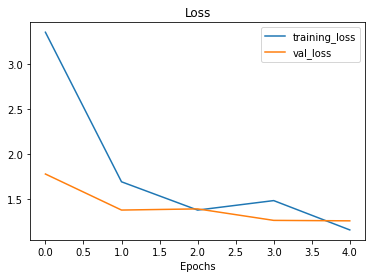

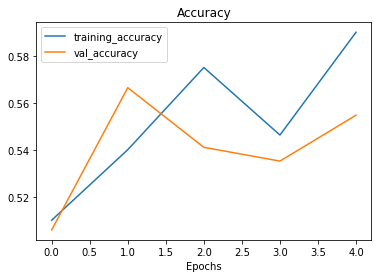

In [ ]:
# Compile & Fit the model

model_5 = tf.keras.Model(inputs, outputs)
model_5.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
history_5 = model_5.fit(
  train_data_10_percent,
  epochs = initial_epochs,
  steps_per_epoch=len(train_data_10_percent),
  validation_data=test_data,
  validation_steps=int(.25 * len(test_data)),
  callbacks=[checkpoint_callback]
)
plot_loss_curves(history_5)

In [ ]:
model_5_results = model_5.evaluate(test_data)

64/64 [==============================] - 6s 86ms/step - loss: 1.2802 - accuracy: 0.5658


## Model 6

In [ ]:
xception_model.trainable = True

# Freeze all layers except the last 30%
for layer in xception_model.layers[:- int(.30 * len(xception_model.layers))]:
  layer.trainable = False



Epoch 5/10
250/250 [==============================] - 51s 190ms/step - loss: 1.7232 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5156
Epoch 6/10
250/250 [==============================] - 46s 184ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 7/10
250/250 [==============================] - 44s 176ms/step - loss: 0.6932 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5078
Epoch 8/10
250/250 [==============================] - 43s 173ms/step - loss: 0.6932 - accuracy: 0.4888 - val_loss: 0.6931 - val_accuracy: 0.5176
Epoch 9/10
250/250 [==============================] - 43s 171ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6930 - val_accuracy: 0.5391
Epoch 10/10
250/250 [==============================] - 44s 173ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6931 - val_accuracy: 0.5059


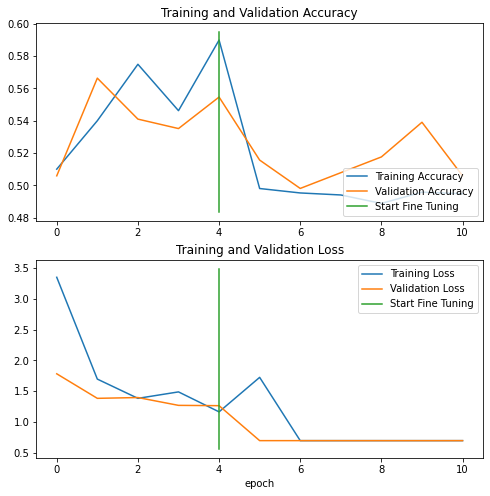

In [ ]:
# # Create new model and recompile & fit
model_6 = tf.keras.Model(inputs, outputs)
model_6.load_weights(checkpoint_path)
model_6.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_6 = model_6.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_5.epoch[-1]
)
compare_historys(history_5, history_6)




In [ ]:
model_6_results = model_6.evaluate(test_data)

64/64 [==============================] - 6s 87ms/step - loss: 0.6931 - accuracy: 0.5000


`Exception` gave us horrible results when unfreezing layers to train on custom data_augmentation
Just to make sure let's create a new xception model and evaluate the data without fitting to see if we could have gotten a better score


## Model 7


In [ ]:
# Create base model
input_shape = (224, 224, 3)

xception_model = tf.keras.applications.Xception(include_top=False)
xception_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = xception_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)



In [ ]:
# Compile & Fit the model

model_7 = tf.keras.Model(inputs, outputs)
model_7.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_7_results = model_7.evaluate(test_data)


64/64 [==============================] - 7s 86ms/step - loss: 11.5973 - accuracy: 0.4560


In [ ]:
model_7_results[1], model_6_results[1]

(0.4559841752052307, 0.5)

Summary: When comparing `model_6` which is trained on custom data and `model_7` which is not trained on custom data, we see that they both perform the same at `~0.5` accuracy

 # Comparing models 

In [ ]:
import pandas as pd
models = [
          model_1_results,
          model_2_results,
          model_3_results,
          model_4_results,
          model_5_results,
          model_6_results,
          model_7_results,
]


results = pd.DataFrame(models, columns=['loss', 'accuracy'])
results

,loss,accuracy
0,0.092076,0.980218
1,0.028466,0.990603
2,14.177300,0.560336
3,0.693161,0.500000
4,1.280248,0.565776
5,0.693148,0.500000
6,11.597263,0.455984


Summary: As we can see, the first 2 models performed the best which run off of EfficientNetB0 and our fine tuned model [2] has the highest accuracy score
Lets's use model_2 to make predictions


# Predictions: EfficientNetB0 Model 2

In [33]:
# # upload file(s)
# from google.colab import files

# uploaded = files.upload()


Saving nugget.jpeg to nugget.jpeg


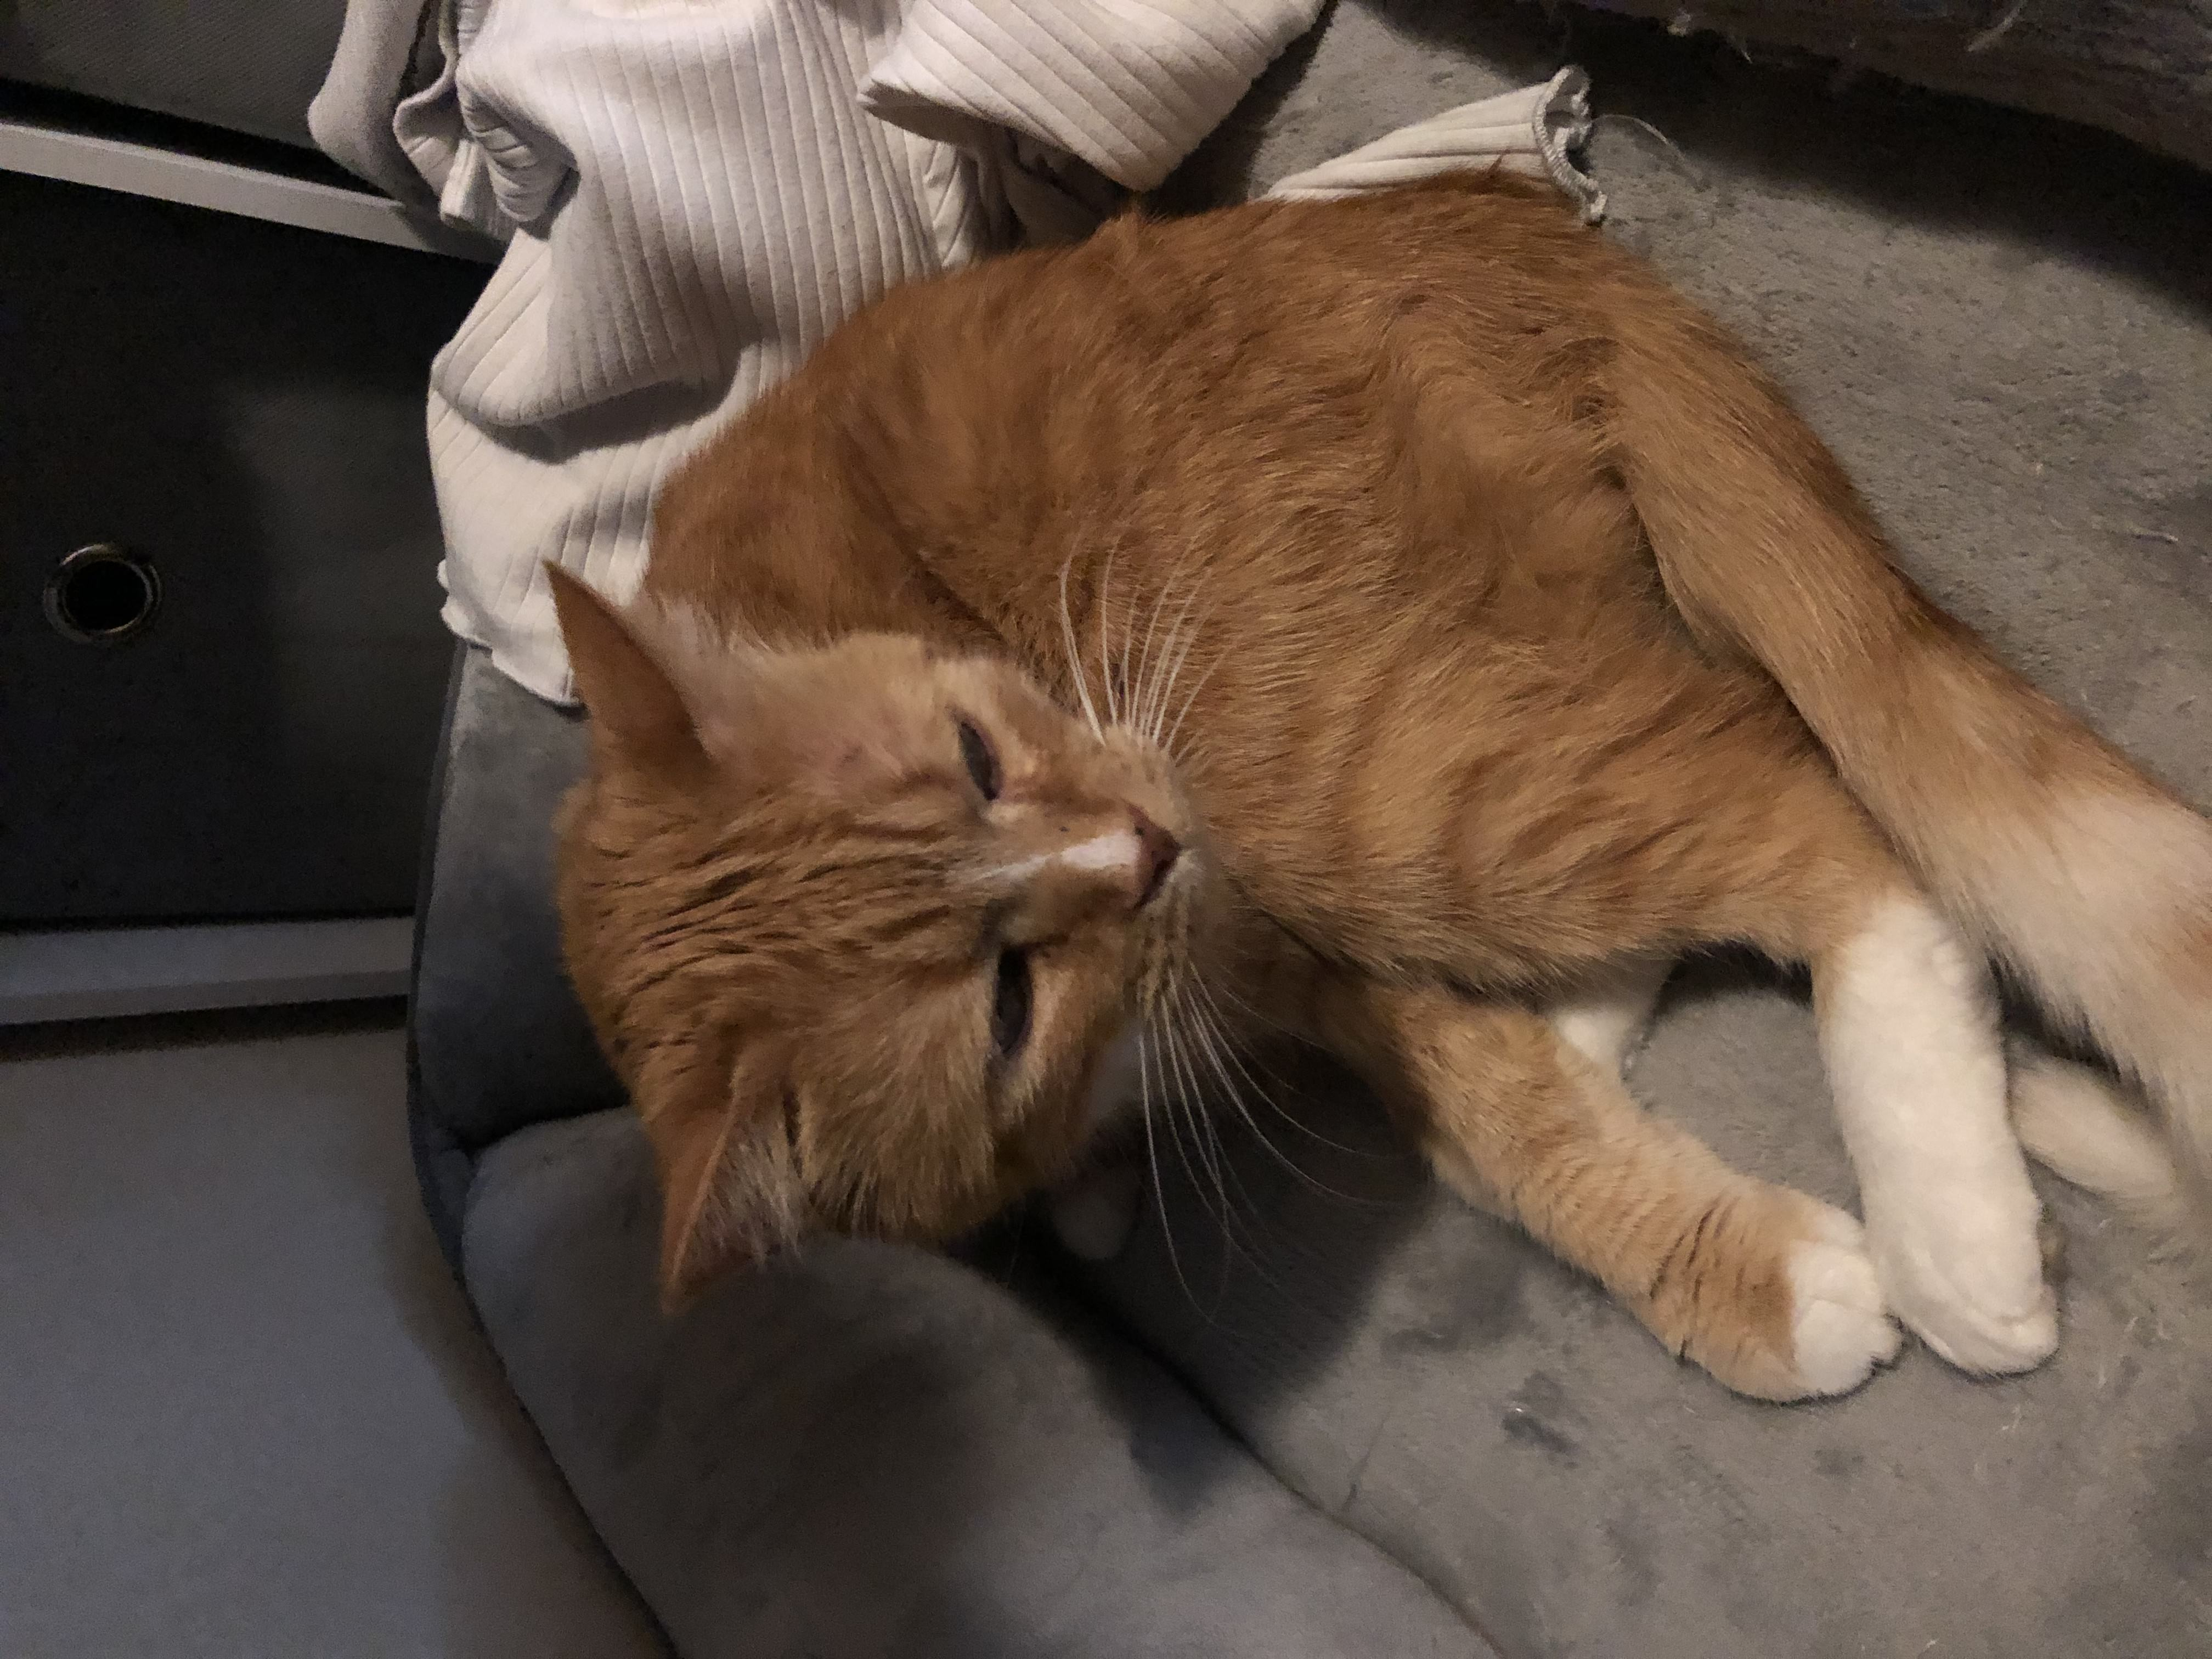

In [32]:
# from IPython.display import Image
# Image(filename='ashley.jpg', width=500, height=300)

In [17]:
# import numpy as np
# from tensorflow.keras.preprocessing import image
# def prepare_image(file):
#   img = image.load_img(file, target_size=(224, 224))
#   img_array = image.img_to_array(img)
#   img_array_expanded_dims = np.expand_dims(img_array, axis=0)
#   return tf.keras.applications.efficientnet.preprocess_input(img_array_expanded_dims)

In [36]:
def decode_prediction(pred):
  val = pred[0][0]
  if val <0.5:
    print('Cat')
  else:
    print('Dog')



In [35]:
# prediction_dog = decode_prediction(model_2.predict(prepare_image('nugget.jpeg'), verbose=1))
# prediction_cat = decode_prediction(model_2.predict(prepare_image('ashley.jpg'), verbose=1))


1/1 [==============================] - 0s 27ms/step
Dog 99.99126195907593
1/1 [==============================] - 0s 23ms/step
Cat 0.02491132472641766
